# Task03 特徵工程

## Task03 目標及內容
### 目標
>進一步特徵分析及數據預處理

### 內容
>1. 缺失異常處理  
2. 特徵構建  
3. 特徵篩選

### 將目標拆解成以下問題：
>Q1：EDA分析出的數據缺失異常如何處理？  
Q2：除了缺失和異常處理，是否需要做轉換或分箱等處理？  
Q3：如何挑選出一組具預測能力但信息不重複的特徵組合？

## O、Task02 EDA結果

**變量類型、缺失值、異常值、分布狀況**

| no | 字段名 | 描述 | 變量類型 | 缺失占比<br>(訓練,測試) | 缺失處理 | 異常值 | 分布 |
|---|:---|:---|:---|:---|:---|:---|:---|
| 01 | SaleID | 交易ID | 編碼 |||||
| 02 | name | 汽車交易名稱 | 編碼 |||| 數值較小部分汽車數量較多 |
| 03 | regDate | 汽車註冊日期 | 日期 ||| 月份有8%為0 | 日期只有1-12 |
| 04 | model | 車型編碼 | 編碼 | (~0%, 無) | 訓練集1筆缺失剔除 || 數值較小部分汽車數量較多 |
| 05 | brand | 汽車品牌 | 類別 |||| 數值較小部分汽車數量較多 |
| 06 | bodyType | 車身類型 | 類別 | (3%, 2.8%) | 需再分析處理 || 各類占比符合常識中各類車輛的普遍性 |
| 07 | fuelType | 燃油類型 | 類別 | (5.8%, 5.8%) | 需再分析處理 || 各類占比符合常識中各種燃油車輛的普遍性 |
| 08 | gearbox | 變速箱 | 類別 (01) | (4%, 3.8%) | 需再分析處理 || 大部分駕駛偏好手動？<br>是否影響自動車輛市場價格？ |
| 09 | power | 發動機功率 | 數值 ||| 約0.1%數據>600為異常值；<br>power=0或太小雖符合字段描述，但實際上並不合理，需再分析處理| 有極大離群值初步判斷為特殊車輛，需再分析 |
| 10 | kilometer | 已行駛公里(萬km) | 數值 ||| 公里數是否有合理需結合車齡進一步判斷 | 並非連續變量，應為分箱選項；<br>大部分>13w，最大值15w因為是分箱數據，所以極可能有大部分>15w |
| 11 | notRepairedDamage | 有尚未修復的損壞 | 類別 (01) | (16%, 16%)<sup>***註1***</sup> | 需再分析處理 || 大多有尚未修復損壞，可考慮和車齡或公里數結合判斷車況 |
| 12 | regionCode | 地區編碼 | 編碼 |||| 數值較小部分汽車數量相對較多 |
| 13 | seller | 銷售方 | 類別 (01) |||| 幾乎全部為個體賣家，僅訓練集中有1筆非個體賣家數據，不宜作為特徵 |
| 14 | offerType | 報價類型 | 類別 (01) |||| 所有數據都是offerType=0，不宜作為特徵 |
| 15 | creatDate | 上線時間 | 日期 |||| 年份2016占絕大多數，不宜作為特徵；<br>月份大部分在3月，其次4月，分布過於不平衡。 |
| 16 | price | 二手車交易價格（預測目標）| 數值 |||| 價格分布偏低，初步推測經過對數轉換或其他預處理。<br>有很多極大離群值，可再挖掘這些離群值是否有共通點。 |
| 17-31 | v_0-v_14 | 匿名特徵 | 數值 ||| v_14 訓練集中有1個明顯極大離群值需剔除 | 許多v系列特徵有分段聚集的現象，需再分析 |

***註1*** 缺失部分以字符串'-'表示，故數字部分也以字符串形式讀取。 因此缺失的'-'部分需替換為空值，並將整個字段轉為float形式。

**相關性分析**

>**變量 vs price**  
1.數值變量：和v_3相關性高；且與許多v特徵高度相關，但關係在v特徵不同區段有所不同（可以考慮對 v 特徵進行分箱處理）。  
2.類別變量：除了seller和offerType因分布不均衡無法判斷，其他類別變量皆有部分類別總體價格偏高的現象  

>**變量間**   
1.數值變量：v系列特徵間相關性偏高，可考慮降維處理

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns',None)
pd.set_option('display.max_rows',None)
import warnings
warnings.filterwarnings("ignore")

In [2]:
train = pd.read_csv('./raw_data/used_car_train_20200313.csv', sep=' ')
test = pd.read_csv('./raw_data/used_car_testA_20200313.csv', sep=' ')

## 一、缺失值處理

>**思路**  
若缺失數據量極少，則直接剔除缺失數據。  
若缺失數據量過多（占大多數），則直接剔除此變量。  
若缺失數據不占多數（仍能提供有效信息），則做補全。
>>補全方法包括：該變量中位數、均值、眾數，建模預測...  

>需注意有時候不需要處理：  
1. 使用XGBoost等決策樹模型
2. 缺失狀況傳達某種信息(例如:賣家填寫車輛信息時，負面車況相關的選項若非必填，則賣家有誘因不填寫)，故此缺失可視為一種類別

>**需處理變量**  
1. model：訓練集1筆缺失剔除
2. bodyType：缺失3%
3. fuelType：缺失6%
4. gearbox：缺失4%
5. notRepairedDamage：缺失16%

### 1. model
訓練集1筆缺失剔除

In [3]:
print('train data before null model preprocessing = {}'.format(train.shape[0]))

print('Remove rows with missing model...')
train_null_m = train.dropna(subset=['model'])

print('train data after null model preprocessing = {}'.format(train_null_m.shape[0]))

train data before null model preprocessing = 150000
Remove rows with missing model...
train data after null model preprocessing = 149999


### 2-4. bodyType, fuelType, gearbox
這三個變量占比並不是特別高，因此暫時先以眾數補全，後續模型若顯示這三個變量預測能力強，再考慮其他較精確但複雜的方式做補全。

In [4]:
train_null_b = train_null_m.copy()
print('count train data null bodyType before = {}'.format(train_null_b.bodyType.isnull().sum()))
train_null_b['bodyType'] = train_null_b['bodyType'].fillna(train_null_b['bodyType'].mode()[0])
print('count train data null bodyType after = {}'.format(train_null_b.bodyType.isnull().sum()))

count train data null bodyType before = 4506
count train data null bodyType after = 0


In [5]:
train_null_f = train_null_b.copy()
print('count train data null fuelType before = {}'.format(train_null_f.fuelType.isnull().sum()))
train_null_f['fuelType'] = train_null_f['fuelType'].fillna(train_null_f['fuelType'].mode()[0])
print('count train data null fuelType after = {}'.format(train_null_f.fuelType.isnull().sum()))

count train data null fuelType before = 8680
count train data null fuelType after = 0


In [6]:
train_null_g = train_null_f.copy()
print('count train data null gearbox before = {}'.format(train_null_g.gearbox.isnull().sum()))
train_null_g['gearbox'] = train_null_g['gearbox'].fillna(train_null_g['gearbox'].mode()[0])
print('count train data null gearbox after = {}'.format(train_null_g.gearbox.isnull().sum()))

count train data null gearbox before = 5981
count train data null gearbox after = 0


### 5. notRepairedDamage

依據 Task02 EDA 結果，此變量缺失的'-'部分需替換為空值，並將整個字段轉為float形式。

In [7]:
train_null_n = train_null_g.copy()
train_null_n['notRepairedDamage'] = train_null_n['notRepairedDamage'].apply(lambda x : float(x) if x!='-' else np.nan)
print('train notRepairedDamage missing count = {}'.format(train_null_n.notRepairedDamage.isnull().sum()))

train notRepairedDamage missing count = 24324


>"是否有未修繕的損壞" 的缺失可能表示**賣家不願透露車況負面信息**，且也可能**影響買家意願**，故不視為缺失，而是作為**第三類別**，即 notRepairedDamage=2，視後續訓練結果決定此方法是否有效。

In [8]:
train_null_n['notRepairedDamage'] = train_null_n['notRepairedDamage'].fillna(value=2)
train_null_n.notRepairedDamage.isnull().sum()
print('train notRepairedDamage missing count = {}'.format(train_null_n.notRepairedDamage.isnull().sum()))
print('train notRepairedDamage==2 count = {}'.format((train_null_n.notRepairedDamage==2).sum()))

train notRepairedDamage missing count = 0
train notRepairedDamage==2 count = 24324


### 缺失值補全結果檢視

In [9]:
train_null_n.isnull().sum()

SaleID               0
name                 0
regDate              0
model                0
brand                0
bodyType             0
fuelType             0
gearbox              0
power                0
kilometer            0
notRepairedDamage    0
regionCode           0
seller               0
offerType            0
creatDate            0
price                0
v_0                  0
v_1                  0
v_2                  0
v_3                  0
v_4                  0
v_5                  0
v_6                  0
v_7                  0
v_8                  0
v_9                  0
v_10                 0
v_11                 0
v_12                 0
v_13                 0
v_14                 0
dtype: int64

## 二、異常值處理
>**需處理變量**  
1. regDate
2. power
3. v_14

### 1. regDate
>月份有8%為0，但目前特徵構造暫不打算使用到月份，所以先不處理。

### 3. power
>1) 約0.1%數據>600為異常值；  
2) power=0或太小雖符合字段描述，但實際上並不合理，需再分析處理

In [10]:
# 1) power>600 部分直接剔除
train_null_p = train_null_n[train_null_n.power<=600]

Text(0, 0.5, 'count')

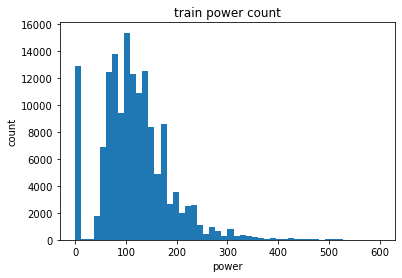

In [11]:
# 2) power=0 或太小部分，先檢視分布狀況
plt.hist(train_null_p.power,bins=50)
plt.title('train power count')
plt.xlabel('power')
plt.ylabel('count')

由上分布圖看到，power=0的部分很多。  
統計power=0 部分占了8.6%，根據常識判斷發動機功率不可能為 0，推估可能原因為數據填寫時默認值即為0。  
因此這裡的 0 等同於缺失值，且占比較大需做補全。

汽車發動機功率和車身類型、燃油類型應該有較高相關性，故以下就power和bodyType, fuelType間關係作分析：

**fuelType vs power**

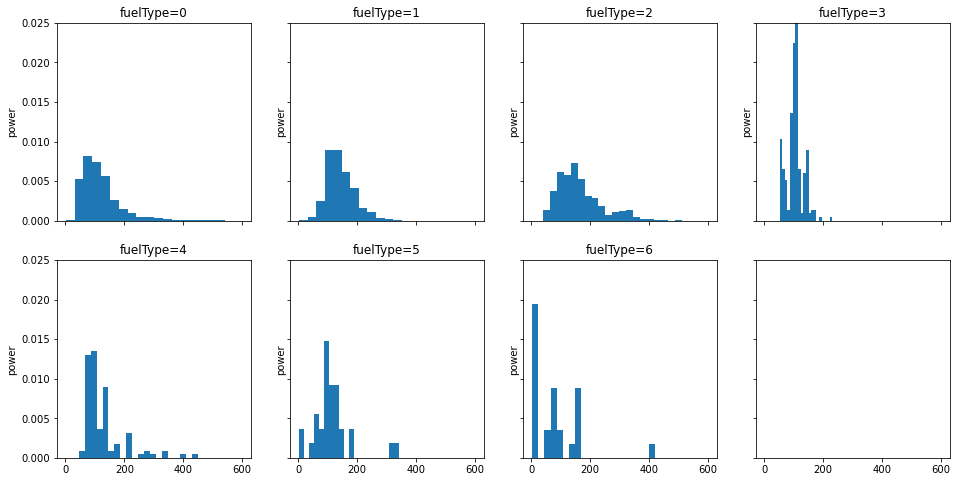

In [12]:
fig, axs = plt.subplots(2, 4, sharex = True, sharey = True, figsize=(16,8))
axs = axs.ravel()

for ft in range(7):
    axs[ft].set_title('fuelType={}'.format(str(ft)))
    if train_null_p[(train_null_p.fuelType==ft)&(train_null_p.power>0)].shape[0]!=0:
        axs[ft].hist(train_null_p[(train_null_p.fuelType==ft)&(train_null_p.power>0)].power, bins=20, density=True)
        axs[ft].set_ylim(0, 0.025)
        axs[ft].set_ylabel('power')

**bodyType vs power**

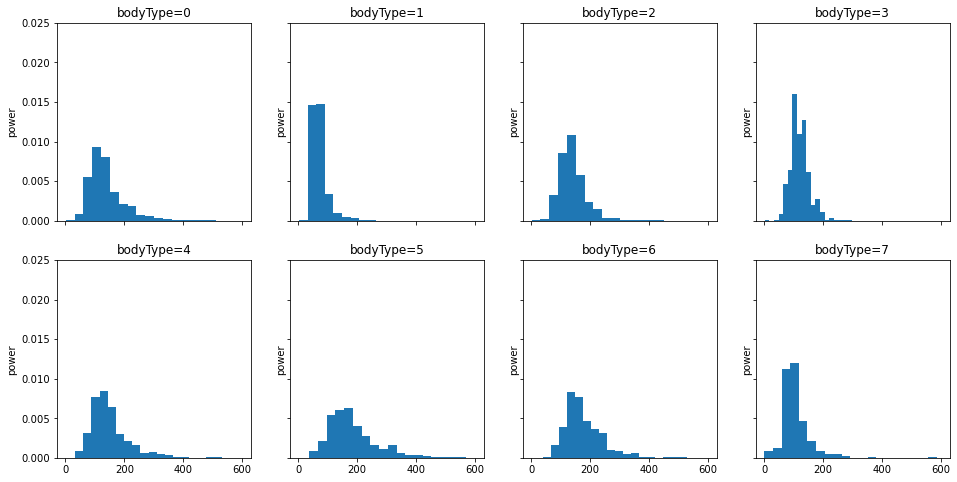

In [13]:
fig, axs = plt.subplots(2, 4, sharex = True, sharey=True, figsize=(16,8))
axs = axs.ravel()

for bt in range(8):
    axs[bt].set_title('bodyType={}'.format(str(bt)))
    if train_null_p[(train_null_p.bodyType==bt)&(train_null_p.power>0)].shape[0]!=0:
        axs[bt].hist(train_null_p[(train_null_p.bodyType==bt)&(train_null_p.power>0)].power, bins=20, density=True)
        axs[bt].set_ylim(0, 0.025)
        axs[bt].set_ylabel('power')

以上power和fuelType, bodyType關係相比之下，以bodyType為分組時，power有較明顯中間部分突出的分布。  
故以bodyType為依據，以bodyType分組後各組power中位數來補全power缺失值。

In [14]:
# 計算各組power中位數
power_median_grouped_by_bodyType = train_null_p[train_null_p.power>0].groupby('bodyType').agg({'power':'median'}).reset_index()
power_median_grouped_by_bodyType.head(10)

,bodyType,power
0,0.0,122
1,1.0,68
2,2.0,140
3,3.0,116
4,4.0,136
5,5.0,170
6,6.0,163
7,7.0,101


In [15]:
# 補全 power 缺失部分
train_null_p['power'] = train_null_p.apply(lambda x : x.power if x.power!=0 else power_median_grouped_by_bodyType.loc[x.bodyType].power, axis=1)

Text(0, 0.5, 'count')

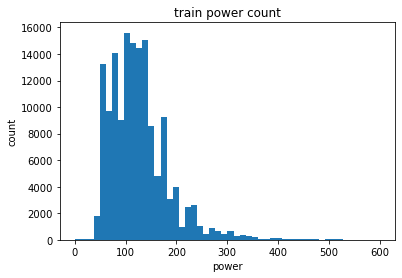

In [16]:
# 檢視power=0部分補全結果
plt.hist(train_null_p.power,bins=50)
plt.title('train power count')
plt.xlabel('power')
plt.ylabel('count')

### 3. v_14

Task02 EDA 箱形圖可以看出訓練集有一個v_14極大異常值需剔除。  
先檢視先前的預處理步驟是否已經剔除此異常值？

Text(0, 0.5, 'v_14')

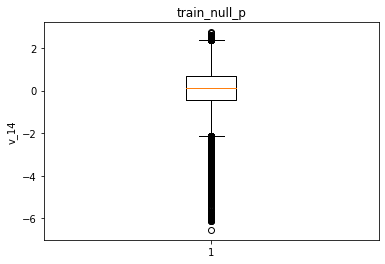

In [17]:
plt.boxplot(train_null_p.v_14)
plt.title('train_null_p')
plt.ylabel('v_14')

由上圖可看出，異常值已經在之前的預處理步驟中被移除，故這部分不需要再做處理。

In [18]:
### 缺失異常處理完畢
train_filtered = train_null_p.copy()

## 三、特徵構造

### 1. 日期變量變換

數據集中有regDate和creatDate兩個日期變量，其中regDate月份數據有異常不適合作為特徵，故目前只考慮年份。  
日期數據實際數值在這個議題中並沒有太大參考價值，但兩日期變量差值則有參考意義：車齡＝註冊日期-上線日期  
（若就長期市場景氣來看，年份應該有一定影響，但數據集中售賣日期只有2015-16且15數據極少，故可忽略此因素）

>車齡 = creatDate 年份 - regDate 年份

In [19]:
train_filtered['age'] = train_filtered.apply(lambda x : int(str(x.creatDate)[:4])-int(str(x.regDate)[:4]), axis=1)

In [20]:
train_filtered.age.describe()

count    149856.000000
mean         12.641723
std           5.362515
min           1.000000
25%           9.000000
50%          13.000000
75%          17.000000
max          25.000000
Name: age, dtype: float64

Text(0, 0.5, 'count')

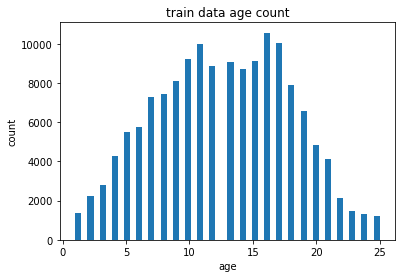

In [21]:
plt.hist(train_filtered.age,bins=50)
plt.title('train data age count')
plt.xlabel('age')
plt.ylabel('count')

以上車齡數據看來沒有異常問題，分布也無特殊情形。

### 2. 分箱

>當數值變量數值本身對預測目標沒有太大解釋力，則分箱為有序類別變量能幫助預測。

**1) age**  
一般而言，買家不會對車齡的絕對數值敏感，而是會將車齡分為幾個階段，直覺上來說，以5年為一個階段是比較常見的，故以5年為一箱。  

| age | age_bin |
|---|---|
| <5 | 0 | 
| 5-9 | 1 |
| 10-14 | 2 |  
| ... | ... |

In [22]:
train_filtered['age_bin'] = train_filtered.age.apply(lambda x : np.ceil(x/5))

In [23]:
age_bin_cnt = pd.DataFrame(train_filtered.age_bin.value_counts())
age_bin_cnt.reset_index(inplace=True)
age_bin_cnt.rename(columns={'index':'age_bin','age_bin':'cnt'},inplace=True)
age_bin_cnt

,age_bin,cnt
0,3.0,45747
1,4.0,39876
2,2.0,37770
3,1.0,16169
4,5.0,10294


Text(0, 0.5, 'count')

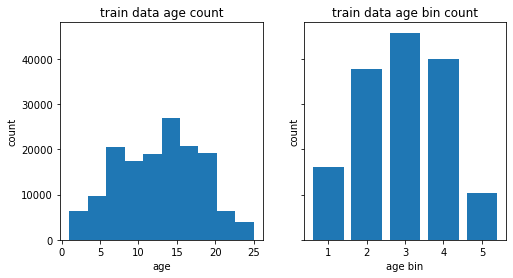

In [24]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))

ax1.hist(train_filtered.age)
ax1.title.set_text('train data age count')
ax1.set_xlabel('age')
ax1.set_ylabel('count')

ax2.bar(age_bin_cnt.age_bin,age_bin_cnt.cnt)
ax2.title.set_text('train data age bin count')
ax2.set_xlabel('age bin')
ax2.set_ylabel('count')

**2) power**  
發動機功率具體數值意義不大，只需知道相對大小 > 每50分一箱

In [25]:
train_filtered['power_bin'] = train_filtered.power.apply(lambda x : np.ceil(x/50))

In [26]:
power_bin_cnt = pd.DataFrame(train_filtered.power_bin.value_counts())
power_bin_cnt.reset_index(inplace=True)
power_bin_cnt.rename(columns={'index':'power_bin','power_bin':'cnt'},inplace=True)
power_bin_cnt

,power_bin,cnt
0,3.0,66044
1,2.0,45720
2,4.0,20913
3,5.0,8283
4,1.0,3714
5,6.0,2420
6,7.0,1708
7,8.0,491
8,9.0,314
9,10.0,105


Text(0, 0.5, 'count')

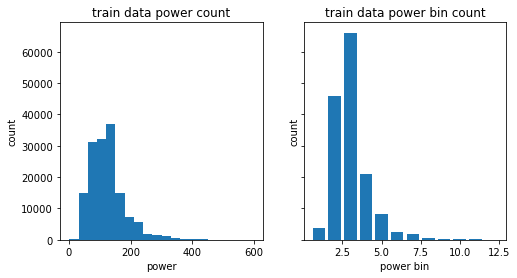

In [38]:
fig, (ax1,ax2) = plt.subplots(1, 2, sharey=True, figsize=(8,4))

ax1.hist(train_filtered.power, bins=20)
ax1.title.set_text('train data power count')
ax1.set_xlabel('power')
ax1.set_ylabel('count')

ax2.bar(power_bin_cnt.power_bin,power_bin_cnt.cnt)
ax2.title.set_text('train data power bin count')
ax2.set_xlabel('power bin')
ax2.set_ylabel('count')

### 3. 統計量特徵

>以一個類別變量分類，取得各類的某數值變量的統計值。  

**price stats grouped by brand**  
price在各品牌的統計量

In [29]:
price_stats_grouped_by_brand = train_filtered.groupby(['brand'])['price'].agg(['median','mean','size','std','max','min']).reset_index()
price_stats_grouped_by_brand.columns = ['brand']+['brand_gp_price_'+s for s in ['median','mean','size','std','max','min']]
price_stats_grouped_by_brand.head()

,brand,brand_gp_price_median,brand_gp_price_mean,brand_gp_price_size,brand_gp_price_std,brand_gp_price_max,brand_gp_price_min
0,0,3199.0,5536.738452,31455,6274.063164,68500,13
1,1,6499.0,9272.585414,13780,9363.917624,99900,15
2,2,7700.0,12037.822430,321,10875.892891,59800,35
3,3,4990.0,6482.822430,2461,5396.327503,37500,65
4,4,6000.0,8538.957297,16720,8460.808379,99999,12


In [30]:
train_filtered = train_filtered.merge(price_stats_grouped_by_brand, on='brand', how='left')
train_filtered.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,age,age_bin,power_bin,brand_gp_price_median,brand_gp_price_mean,brand_gp_price_size,brand_gp_price_std,brand_gp_price_max,brand_gp_price_min
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60.0,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,12,3.0,2.0,1800.0,3607.928375,10206,4650.025544,40950,13
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,140.0,15.0,2.0,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,13,3.0,3.0,6499.0,9272.585414,13780,9363.917624,99900,15
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163.0,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,12,3.0,4.0,8500.0,9858.582990,1458,5425.058140,45000,100
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193.0,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,20,4.0,4.0,5400.0,8449.322819,14234,8916.556379,98000,15
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68.0,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,4,1.0,2.0,2300.0,3306.375375,4662,3344.689763,31500,20


**price stats grouped by bodyType**  
price在各車身類型的統計量

In [31]:
price_stats_grouped_by_bodyType = train_filtered.groupby(['bodyType'])['price'].agg(['median','mean','size','std','max','min']).reset_index()
price_stats_grouped_by_bodyType.columns = ['bodyType']+['bodyType_gp_price_'+s for s in ['median','mean','size','std','max','min']]
price_stats_grouped_by_bodyType

,bodyType,bodyType_gp_price_median,bodyType_gp_price_mean,bodyType_gp_price_size,bodyType_gp_price_std,bodyType_gp_price_max,bodyType_gp_price_min
0,0.0,3000,5684.936548,45877,6884.557748,99999,11
1,1.0,1600,2790.191765,35241,3159.663046,99999,12
2,2.0,3500,5820.259655,30294,6320.798831,69900,15
3,3.0,4500,6615.329773,13482,6762.787770,89000,20
4,4.0,6300,9687.349130,9601,10698.904379,99900,39
5,5.0,5500,10269.207182,7602,12335.946323,99999,20
6,6.0,10950,13307.441013,6476,10728.784360,99999,50
7,7.0,2490,4035.851910,1283,5574.281628,99990,40


In [32]:
train_filtered = train_filtered.merge(price_stats_grouped_by_bodyType, on='bodyType', how='left')
train_filtered.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,regionCode,seller,offerType,creatDate,price,v_0,v_1,v_2,v_3,v_4,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,age,age_bin,power_bin,brand_gp_price_median,brand_gp_price_mean,brand_gp_price_size,brand_gp_price_std,brand_gp_price_max,brand_gp_price_min,bodyType_gp_price_median,bodyType_gp_price_mean,bodyType_gp_price_size,bodyType_gp_price_std,bodyType_gp_price_max,bodyType_gp_price_min
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60.0,12.5,0.0,1046,0,0,20160404,1850,43.357796,3.966344,0.050257,2.159744,1.143786,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,12,3.0,2.0,1800.0,3607.928375,10206,4650.025544,40950,13,1600,2790.191765,35241,3159.663046,99999,12
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,140.0,15.0,2.0,4366,0,0,20160309,3600,45.305273,5.236112,0.137925,1.380657,-1.422165,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,13,3.0,3.0,6499.0,9272.585414,13780,9363.917624,99900,15,3500,5820.259655,30294,6320.798831,69900,15
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163.0,12.5,0.0,2806,0,0,20160402,6222,45.978359,4.823792,1.319524,-0.998467,-0.996911,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,12,3.0,4.0,8500.0,9858.582990,1458,5425.058140,45000,100,1600,2790.191765,35241,3159.663046,99999,12
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193.0,15.0,0.0,434,0,0,20160312,2400,45.687478,4.492574,-0.050616,0.883600,-2.228079,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,20,4.0,4.0,5400.0,8449.322819,14234,8916.556379,98000,15,3000,5684.936548,45877,6884.557748,99999,11
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68.0,5.0,0.0,6977,0,0,20160313,5200,44.383511,2.031433,0.572169,-1.571239,2.246088,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,4,1.0,2.0,2300.0,3306.375375,4662,3344.689763,31500,20,1600,2790.191765,35241,3159.663046,99999,12


### 4. 歸一化、標準化

目前考慮使用樹模型，先不需要做此處理。

## 四、特徵篩選

### 相關性分析

In [33]:
# 所有特徵
train_filtered.columns

Index(['SaleID', 'name', 'regDate', 'model', 'brand', 'bodyType', 'fuelType',
       'gearbox', 'power', 'kilometer', 'notRepairedDamage', 'regionCode',
       'seller', 'offerType', 'creatDate', 'price', 'v_0', 'v_1', 'v_2', 'v_3',
       'v_4', 'v_5', 'v_6', 'v_7', 'v_8', 'v_9', 'v_10', 'v_11', 'v_12',
       'v_13', 'v_14', 'age', 'age_bin', 'power_bin', 'brand_gp_price_median',
       'brand_gp_price_mean', 'brand_gp_price_size', 'brand_gp_price_std',
       'brand_gp_price_max', 'brand_gp_price_min', 'bodyType_gp_price_median',
       'bodyType_gp_price_mean', 'bodyType_gp_price_size',
       'bodyType_gp_price_std', 'bodyType_gp_price_max',
       'bodyType_gp_price_min'],
      dtype='object')

In [34]:
numeric_features = ['power','age'] + \
                    ['brand_gp_price_'+s for s in ['median','mean','size','std','max','min']] + \
                    ['bodyType_gp_price_'+s for s in ['median','mean','size','std','max','min']]
numeric_features

['power',
 'age',
 'brand_gp_price_median',
 'brand_gp_price_mean',
 'brand_gp_price_size',
 'brand_gp_price_std',
 'brand_gp_price_max',
 'brand_gp_price_min',
 'bodyType_gp_price_median',
 'bodyType_gp_price_mean',
 'bodyType_gp_price_size',
 'bodyType_gp_price_std',
 'bodyType_gp_price_max',
 'bodyType_gp_price_min']

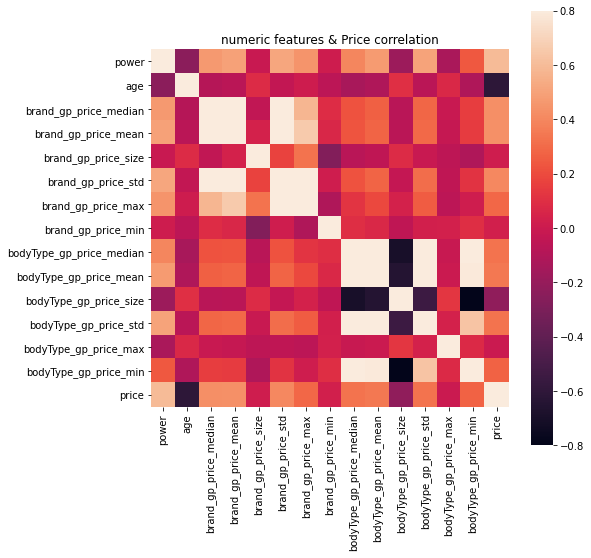

In [35]:
# 相關係數熱力圖
corr = train_filtered[numeric_features+['price']].corr()

f , ax = plt.subplots(figsize = (8, 8))
plt.title('numeric features & Price correlation')
sns.heatmap(corr,square = True, vmax=0.8)

+ price和其他特徵相關性：  
    和車齡呈高度負相關；  
    和其他統計量特徵看來並沒有太高的相關性。  
    
+ 特徵間相關性：  
    除了統計變量間本身就高相關之外，bodyType_gp_size(各車身類型的車數)和以bodyType分組後price的統計量間(除了max)都呈高度附相關。  
    此現象表示該車身類型樣本越少時，其統計量易受極大離群值影響。

## 總結 - 所有預處理
### 缺失異常處理
>1. 剔除訓練集中model缺失的1筆數據  
2. bodyType, fuelType, gearbox 以眾數補全  
    (以訓練集眾數補全，但依據訓練及測試集數據分布來看，兩者分布基本相同故眾數應相同)  
3. notRepairedDamage：'-'部分需替換為空值，並將整個字段轉為float形式；空值視為第三類別=2  
4. power：剔除>600部分；訓練集 power==0部分視為缺失，並用訓練集 power 以 bodyType 分組後各組中位數來補全  

### 特徵構造
>1. "age" = createDate年份 - regDate年份  
2. "age_bin" = "age"每五年分一箱  
3. "power_bin" = "power"每50分一箱
4. price在各brand的統計量 > ['price_brand_gp_'+s for s in ['median','mean','std','max','min']]+['brand_gp_size']  
5. price在各bodyType的統計量 > ['price_bodyType_gp_'+s for s in ['median','mean','std','max','min']]+['bodyType_gp_size']